In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/brdd/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    
import helper_functions as hlp
import function_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import plot_function_gradcam as pgc

/tf


## Load Data

In [3]:
# Define the path + output path:
DATA_DIR = DIR + "data/"

version = "10Fold_sigmoid_V0" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

# Define Model Version
model_version = 1

if version.startswith("10Fold"):
    WEIGHT_DIR = DIR + "weights/" + version + "/"
    OUTPUT_DIR = DIR + "pictures/" + version + "/"
    pic_save_name = "10Fold_ensembling" + version[6:]
    
elif version == "andrea":
    WEIGHT_DIR = DIR + "weights/andrea_split/"
    OUTPUT_DIR = DIR + "pictures/andrea_split/"
    pic_save_name = "andrea_split"

In [4]:
## load images and ids

if version == "andrea": ## for andrea
    with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
        # with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
        # both images are the same
            X_in = h5["X"][:]
            pat = h5["pat"][:]
            
    # load results
    path_results = DATA_DIR + "all_tab_results_andrea_split.csv" # andrea split
    
elif version.startswith("10Fold"): ## for 10 Fold       
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
        num_models = 5
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
        num_models = 10
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
        num_models = 5
    elif version.endswith("V3"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3.csv", sep=",")
        num_models = 5
    pat = id_tab["p_id"].to_numpy()
    X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
    
    # load results
    path_results = DATA_DIR + "all_tab_results_" + version + "_M" + str(model_version) + ".csv" # 10 Fold

all_results = pd.read_csv(path_results, sep=",")
all_results = all_results.sort_values("p_idx")

In [5]:
## load patient data
PAT_CSV_DIR = "/tf/notebooks/hezo/stroke_zurich/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")
pat_dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia,iaty,ivty
0,101,1,"85,6",0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN
1,102,1,"66,7",1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN
2,103,0,"29,2",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,104,0,83,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,NaN,NaN
4,105,6,"89,2",0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,540,2,80,0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0
514,541,0,19,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1
515,542,1,68,1,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0
516,543,4,74,0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0


## Model

In [6]:
# define model
input_dim = (128, 128, 28, 1)

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    LOSS = "binary_crossentropy"
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    LOSS = tf.keras.losses.categorical_crossentropy
    
if version.endswith("f"):
    layer_connection = "flatten"
else:
    layer_connection = "globalAveragePooling"

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [7]:
# Define Model Name
def generate_model_name(which_split, model_nr, model_version = model_version, path = WEIGHT_DIR):
    if layer_connection == "globalAveragePooling":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_avg_layer_paper_model_" + last_activation + "_activation_"  + str(model_version) + str(model_nr) + ".h5")
    elif layer_connection == "flatten":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_flat_layer_paper_model_" + last_activation + "_activation_" + str(model_version) + str(model_nr) + ".h5")

In [8]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

# GradCam Slider

In [9]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, Layout, AppLayout
from IPython.display import display
from termcolor import colored
import ipywidgets as widgets

from importlib import reload
reload(pgc)
reload(gc)

def gradcam_interactive_plot(p_id, pred_hm_only=True):
    p_ids = [p_id]
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)
    
    print("patient id: ", res_table.p_id[0])
    print("age: ", pat_dat[pat_dat["p_id"] == res_table.p_id[0]]["age"].values[0])
    print("true mrs: ", res_table.mrs[0])
    print("true class: ", res_table.unfavorable[0])
    print(colored("pred class: "+str(res_table.y_pred_class[0]), 
                'green' if res_table["pred_correct"][0] == True else 'red'))
    print("pred prob (class 1): ", res_table.y_pred_trafo_avg[0])
    print("pred uncertainty: ", res_table.y_pred_unc[0])
    # print("heatmap unc. last layer: ", res_table.y_pred_unc[0])
    
    ## Generate heatmap
    if pred_hm_only:
        invert_hm = "all" if res_table.y_pred_class[0] == 0 else "none"
        gcpp_hm = "last"
        cmap = "jet"
        hm_positive=True
    else:
        invert_hm = "none"
        gcpp_hm = "none"
        cmap = "bwr"
        hm_positive=False
    
            
    heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
        img = np.expand_dims(res_images[0], axis = 0), 
        cnn = model_3d,
        model_names = res_model_names[0],
        layers = vis_layers[3],
        model_mode = "mean",
        pred_index = 0,
        invert_hm = invert_hm,
        gcpp_hm = gcpp_hm)

    slices = np.unravel_index(heatmap.argmax(), heatmap.shape)
    print("max slices:", (slices[2], slices[0], slices[1]))
    
    ## Plot Heatmap Average
    pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)

    ## Plot Heatmap Slider
    def slicer(axi_slider, cor_slider, sag_slider):
        pgc.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "def",
                slices = (cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)
        pgc.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "def",
                slices=(cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                slice_line=True)

    w=interactive(
        slicer, 
        axi_slider=widgets.IntSlider(value=slices[2],min=0,max=27,step=1), 
        cor_slider=widgets.IntSlider(value=slices[0],min=0,max=127,step=1), 
        sag_slider=widgets.IntSlider(value=slices[1],min=0,max=127,step=1))

    slider_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='9.2in')
    images_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='15', height='15')

    display(VBox([
        HBox([w.children[0],w.children[1], w.children[2]], layout=slider_layout),
        HBox([w.children[3]], layout=images_layout)
    ]))      
    w.update()

patient id:  485
age:  89
true mrs:  4.0
true class:  1
pred class: 1
pred prob (class 1):  0.27072114
pred uncertainty:  0.326225
max slices: (4, 36, 75)


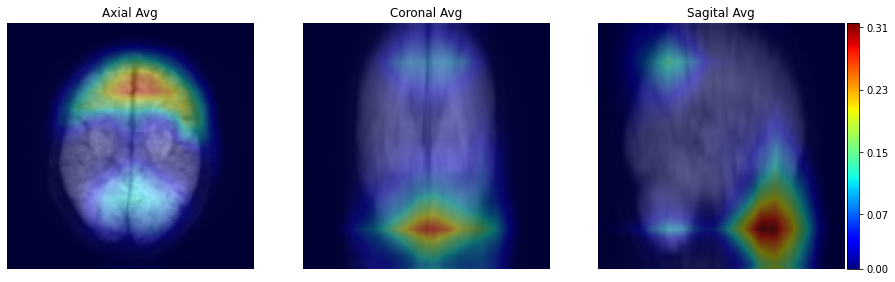

In [12]:
gradcam_interactive_plot(485, pred_hm_only=True)
